# 향후 판매량 예측 경진대회 이해
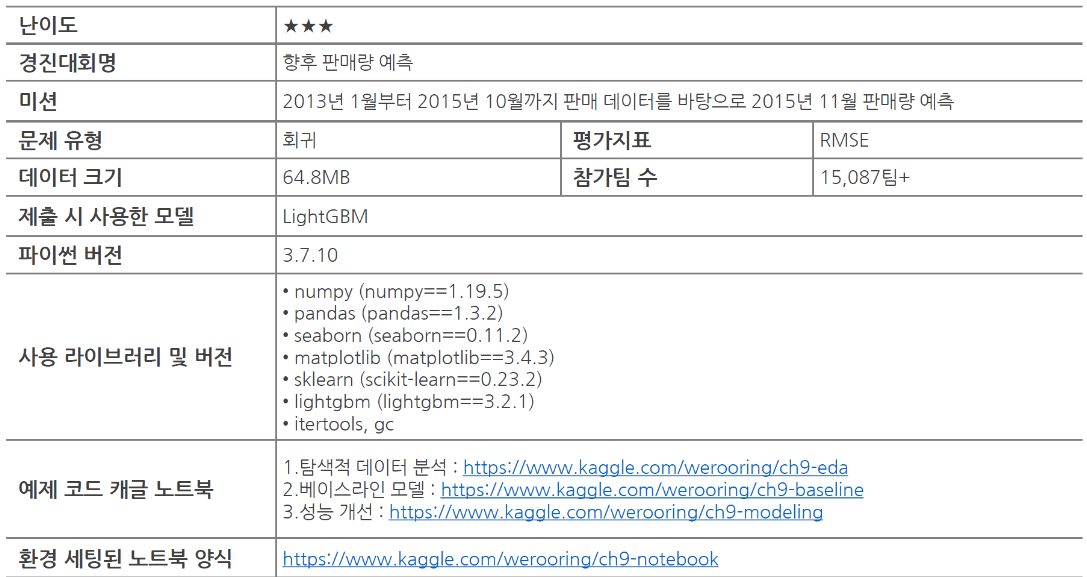

### 학습 목표
- 다양한 피처 엔지니어링 기법을 배워봅시다!

### 학습 키워드
- 유형 및 평가지표: 회귀, RMSE
- 탐색적 데이터 분석: 데이터 병합, 그룹화
- 머신러닝 모델: LightGBM
- 피처 엔지니어링: 피처명 한글화, 데이터 다운캐스팅, 조합, 이어 붙이기, 병합, 이상치 제거, 파생 피처 생성
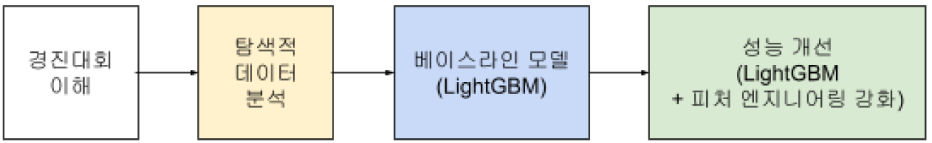

### 경진대회 Overview
- 과거 판매 데이터를 토대로 향후 판매량 예측
 - 타깃값은 판매량이므로 범주형 데이터가 아님. 따라 회귀 문제에 속함
- 주어진 데이터는 2013년 1월부터 2015년 10월까지의 일별 판매 내역
 - 더불어 상점, 상품, 상품분류에 관한 추가 데이터도 있음
 - 이 데이터를 기반으로 2015년 11월 각 상점의 상품별 월간 판매량을 예측해야 함
 - 피처: 상점 및 상품에 관한 정보, 타깃값: 월간 판매량-> 주어진 타겟은 일간으로 되어있기 때문에 월간으로 바꿔주는 작업 필요함
- 주의점
 - 상품별 월간 판매량(타깃값)은 0개에서 20개 사이여야 함
 - 타깃값뿐만 아니라 판매량과 관련된 피처는 모두 0~20 사이로 값을 제한해야 함
 
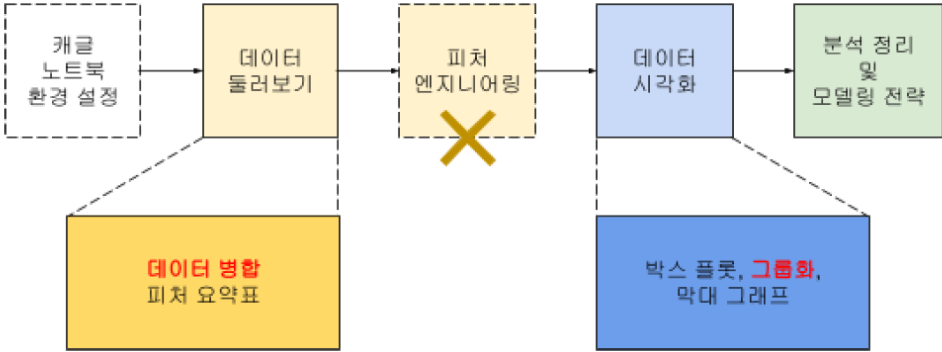

# 9.2 향후 판매량 예측 경진대회 탐색적 데이터 분석

## 9.2.1 데이터 둘러보기

In [2]:
import pandas as pd

# 데이터 경로
data_path = 'C:\\vscode\\kaggle\\dataset\\Predict Future Sales_dat\\'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

### sales_train 데이터

In [8]:
sales_train
# 판매량 -1 -> 대회에서 명시하지 않음 - 오류일지 환불인지 모름 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0



# 메모리관리X -> 모델훈련시 메모리 터져서 캐글 환경 터짐 
# 메모리 관리 필요
# 간단한 코드 중간중간에 넣어주면 끝 

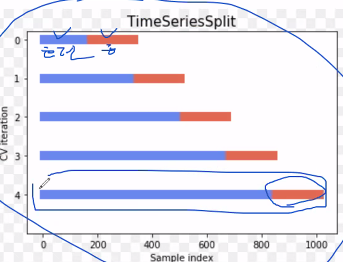

- date_block_num은 편의상 사용하는 날짜(월) 구분자: 0은 2013년 1월, 1은 2013년 2월, 33은 2015년 10월
- 최종적으로 월별 판매량을 구해야 하니 ‘월’ 구분자(date_block_num)만 있으면 됨, 따라서 date 피처 삭제

#### **<font color='orange'>[분석 결과] 월별 판매량만 구하면 되니 date 피처 제거</font>**

- item_cnt_day 피처는 당일 판매량
- 타깃값은 ‘월간’ 판매량이므로, date_block_num(월구분자) 피처를 기준으로 그룹화해서 item_cnt_day 값을 합하면 타깃값이 됨

#### **<font color='orange'>[분석 결과] 타깃값 = date_block_num 피처의 값이 같은 데이터들의 item_cnt_day 값의 합</font>**


- 본 데이터는 시계열 데이터이므로 시간 흐름 자체가 중요한 정보
- 그렇기 때문에 2013년 1월 ~ 2015년 9월까지 판매 내역을 훈련 데이터, 2015년 10월 판매 내역을 검증 데이터로 사용

#### **<font color='orange'>[분석 결과] 훈련 데이터 중 가장 최근인 2015년 10월 판매 내역을 검증 데이터로 사용</font>**
나머지는 훈련데이터 / 훈련 vs 검증데이터 보통 8:2 / 데이터크기 큰경우 9:1도 충분함 


시계열 데이터 X -> 일반적인 교차검증(validation set 활용하여) k-fold하면 안됨

시계열 데이터 o -> 미래 훈련데이터는 사용 X -> 미래를 활용하여 과거를 예측할 수는 없기 때문

끝쪽 데이터만 검증데이터로 활용하면 예측성능 떨어지지 않는가?(시계열이므로 뒤쪽데이터를 검증데이터로 활용해야함)
대안 -> time series split 

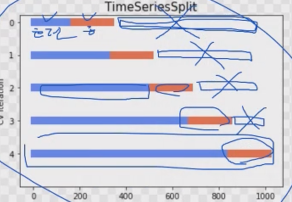

미래 훈련데이터는 사용하지 않음 

-> 모든데이터를 검증데이터로 활용하면서 시간흐름반영함

In [10]:
sales_train.info(show_counts=True)
# show_counts=True ->데이터 너무 클시 활용하여 Non-Null Count값 반환
#결측값은 없지만 메모리 너무큼

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


- 메모리 사용량을 가능한 한 줄여주는 게 바람직

#### **<font color='orange'>[분석 결과] 메모리 관리 필요 </font>**
훈련속도 빠르게 하기 위해 

->간단한 코드 중간중간에 넣어주면 끝 

### shops 데이터

In [6]:
sales_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [7]:
shops.head() # 러시아어로 쓰임 / 정보추출 어려움 / 다른 캐글러가 정보공유해줌
# 상점 이름의 1번째 단어는 상점이 위치한 도시 

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


- 상점명(shop_name)은 러시아어로 기재됨, 상점명의 첫 단어는 상점이 있는 도시를 나타냄
- 상점 ID(shop_id)는 sales_train에도 있는 피처, 그러므로 shop_id를 기준으로 sales_train과 shops를 병합

#### **<font color='orange'>[분석 결과] 상점 이름의 첫 단어는 도시를 뜻함 </font>**

#### **<font color='orange'>[분석 결과] shop_id를 기준으로 sales_train과 shops 병합 </font>**

In [12]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


- 상점은 딱 60개만 있음
- 결측값도 없고, 데이터 개수가 적어서 메모리 사용량도 1.1KB 정도로 적음

### items 데이터

In [13]:
items.head()
# 상품명이랑 아이디랑 일대일 매칭 동일한 의미 -> 상품명 제거 

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


- 상품명(러시아어), 상품 ID, 상품분류 ID로 구성
- 상품명에서는 유용한 정보를 얻기 어려워 모델링 시 제거
- item_id 피처는 sales_train에도 존재, 따라서 item_id 피처를 기준으로 sales_train과 items 병합 가능

#### **<font color='orange'>[분석 결과] 상품명 피처 제거 </font>**

#### **<font color='orange'>[분석 결과] item_id를 기준으로 sales_train과 items 병합 </font>**

In [14]:
sales_train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0


In [15]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


### item_categories 데이터

In [16]:
sales_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [17]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


- 상품분류명과 상품분류 ID로 구성
- sales_train에도 item_category_id 피처가 있어서, 이 피처를 기준으로 sales_train과 item_categories 병합
- 상품분류명의 첫 단어는 대분류를 뜻함

#### **<font color='orange'>[분석 결과] item_category_id를 기준으로 sales_train과 item_categories 병합 </font>**

#### **<font color='orange'>[분석 결과] 상품분류명에서 첫 단어는 대분류 </font>**

In [18]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


#### **<font color='orange'>[분석 결과] 모든 데이터에 결측값 없음 </font>**

### 테스트 데이터

In [21]:
test
# shop_id의 상점에서 item_id의 물건이 몇개 팔렸는지 예측해라  
# 날짜 따로 안나옴 - 처음에 소개글에서 설명해줬기 때문(2015년 11월 값)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


### 제출 샘플 데이터

In [26]:
submission.head(7) 
# 그 예측값을 item_cnt_month에 넣어라 

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
5,5,0.5
6,6,0.5


### 데이터 병합
- 피처 요약표를 만들고 시각화를 하기 위해 데이터 병합
 - 앞서 설명한 바와 같이 특정 피처를 기준으로 병합
 - 판다스 merge( ) 함수로 구현
- sales_train, shops, items, item_categories를 모두 병합해 그 결과를 train에 할당

- EDA단계 병합 - 일단 한번 시각화 해보려고 


1. 왼쪽 테이블 기준으로 병합

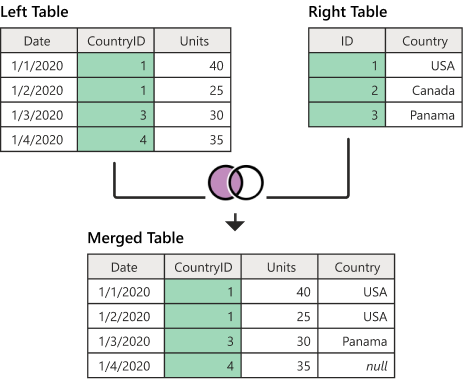

2. 오른쪽 테이블 기준으로 병합

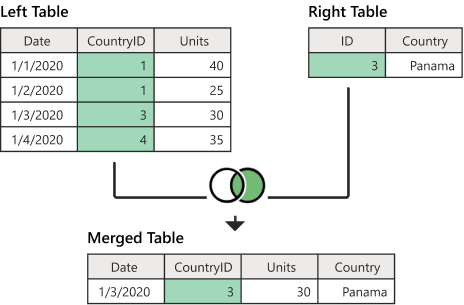

In [28]:
train = sales_train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')

train.head()

# on = 공통된 피쳐(기준피쳐) / how ='left' 레프트 조인 / right -> 라이트 조인
# 각각 제공된 데이터를 기준 피쳐 바탕으로 한 train 데이터로 합침 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


### 피처 요약표 만들기
- 데이터 타입, 결측값 개수, 고윳값 개수, 첫 번째 값, 두 번째 값을 포함한 피처 요약표 만들기(p.622)


In [29]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    
    return summary

In [31]:
resumetable(train)
# 한눈에 보기 쉽게 그려줌 / 큰그림 보게 / 귀찮더라도 하는 습관 기르기 

#shop_name,shop_name -> 고유값 60개 -> 1대1 매칭됨 / 둘중하나 제거가능 
# 평균값 추가 등 본인만의 피쳐요약표 만들 수 있음 


데이터 세트 형상: (2935849, 10)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,date,object,0,1034,02.01.2013,03.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,2552
4,item_price,float64,0,19993,999.0,899.0
5,item_cnt_day,float64,0,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


- shop_id와 shop_name, item_id와 item_name, item_category_id와 item_category_name 피처의 고윳값 개수가 서로 같음

#### **<font color='orange'>[분석 결과] 상점ID, 상품ID, 상품분류ID는 각각 상점명, 상품명, 상품분류명과 1:1 매칭되므로 둘 중 하나 제거 </font>**

## 9.2.2 데이터 시각화
- 병합한 train을 이용해 데이터 시각화
- 피처 개수가 많지 않고, 그중 일부는 식별자거나 문자 데이터라서 시각화할 게 별로 없음
- 수치형 데이터도 적음 

### 일별 판매량
- train에서 식별자나 문자 데이터를 빼면 item_cnt_day 피처와 item_price 피처만 남음
- 우선 item_cnt_day 피처 시각화

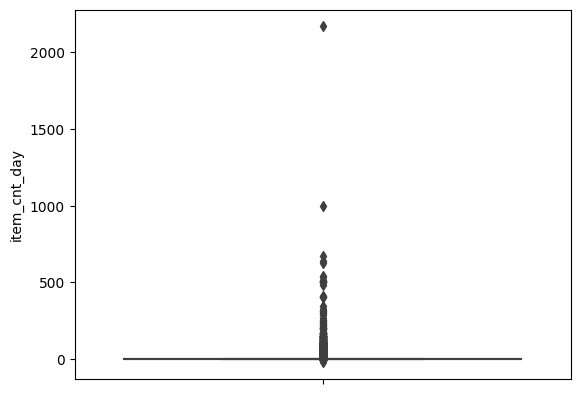

In [32]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.boxplot(y='item_cnt_day', data=train);

- 이상치가 많아서 박스플롯 모양이 이상함 / 이상치 제거 - anomaly detection -> 엄청 어려운 분야 / 통계값 기준 이상치 처리 명확 기준없음
처음 - 대충 눈대중으로 지우기
- 과한 이상치는 제거해야 함
- 여기선 item_cnt_day 1,000 이상인 데이터 제거 / 

#### **<font color='orange'>[분석 결과] 일별 판매량 1,000 이상인 데이터(이상치) 제거 </font>**

### 상품 가격

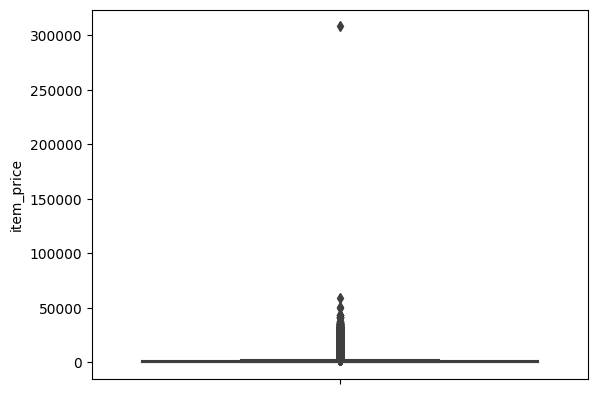

In [35]:
sns.boxplot(y='item_price', data=train);

- 300,000루블(약 450만 원)이 넘는 판매가 때문에 박스플롯 모양이 역시 납작함
- 추후 판매가 50,000루블 이상인 이상치는 제거

#### **<font color='orange'>[분석 결과] 판매가 50,000 이상인 데이터(이상치) 제거 </font>**

### 그룹화(그루핑)
- 특정 피처를 기준으로 그룹화해서 시각화
 - 다음 코드는 train의 date_block_num 피처를 기준으로 그룹화해 item_cnt_day 피처 값의 합(sum)을 구하는 코드 (월별(date_block_num) 월간 판매량(item_cnt_day의 합)을 구한다는 말)

In [34]:
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.0,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил


In [38]:
group = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group.reset_index() # 인덱스 재설정

# 월구분자 기준(date_block_num) 그루핑 -> 일간판매량 합침 
# 다 나누지 않고 전체 총 판매량을 계산해주기 

# 상품별 상점별 원래 구분해서 표현해야하지만 시간관계상 그냥 월별 총 판매량('item_cnt_day') 표현 

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


- reset_index( )를 호출하지 않으면 그룹화한 date_block_num 피처가 인덱스로 설정됨
- 그래프를 그릴 때 date_block_num 피처를 사용해야 해서 인덱스를 재설정함

#### groupby 원리
- 한 개 이상 피처를 기준으로 데이터 분리 (앞 코드에서 기준이 되는 피처는 date_block_num)
- 분리된 각 그룹에서 함수를 적용해 집곗값 구함 (앞 코드에서는 agg( ) 메서드로 item_cnt_day 피처에 ‘sum’ 함수를 적용해 판매량 합계를 구함)
- 기준 피처별로 집곗값 결과를 하나로 결합

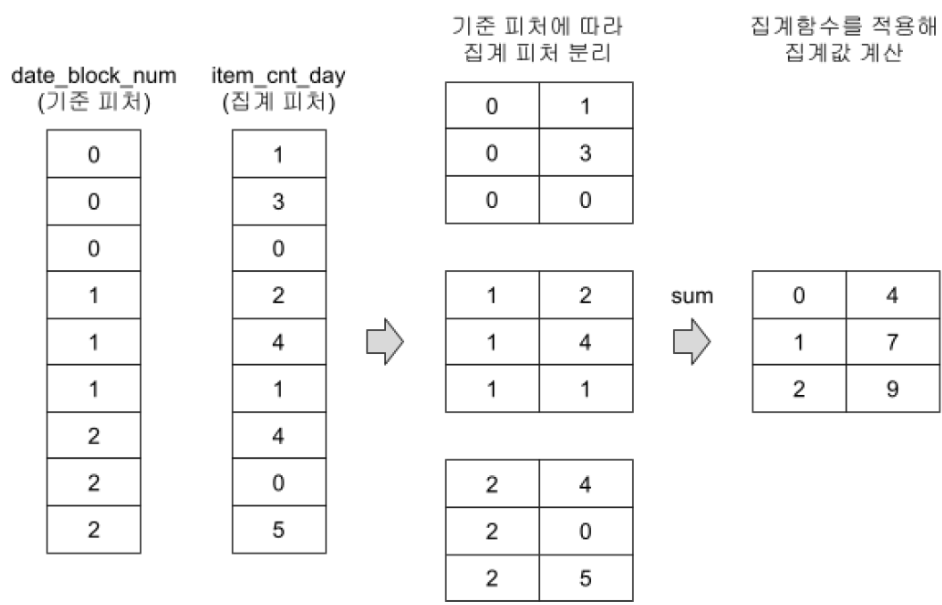

### 월별 판매량
- groupby 합 연산 결과인 group을 활용해 시각화 (= 월별 판매량)
-  수치형 데이터 2개뿐이라 특별히 시각화해볼거 별로 없음 |

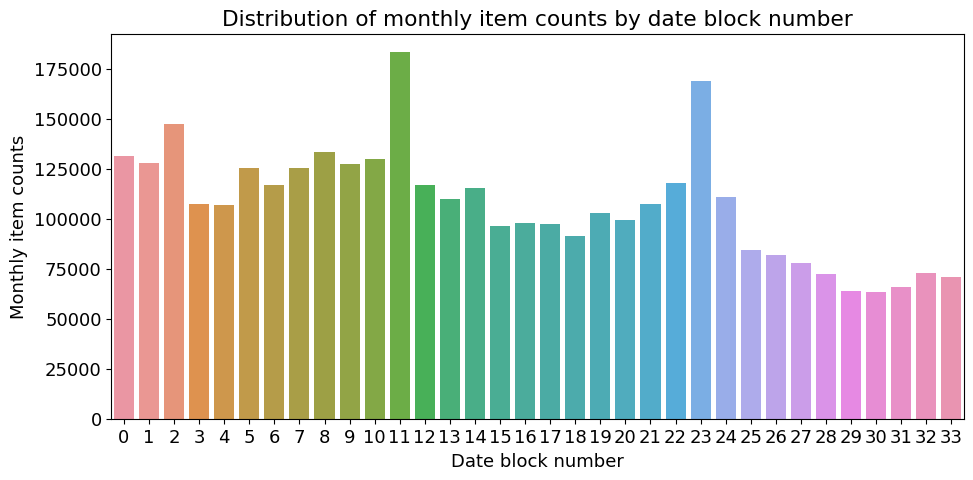

In [40]:
mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# 월별 총 상품 판매량
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group_month_sum = group_month_sum.reset_index()

# 월별 총 상품 판매량 막대그래프
sns.barplot(x='date_block_num', y='item_cnt_day', data=group_month_sum)
# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

-> 월말에 피크를 찍는구나

### 상품분류별 판매량
- 월간 판매량 10,000개 초과인 상품분류만 추출해서 시각화

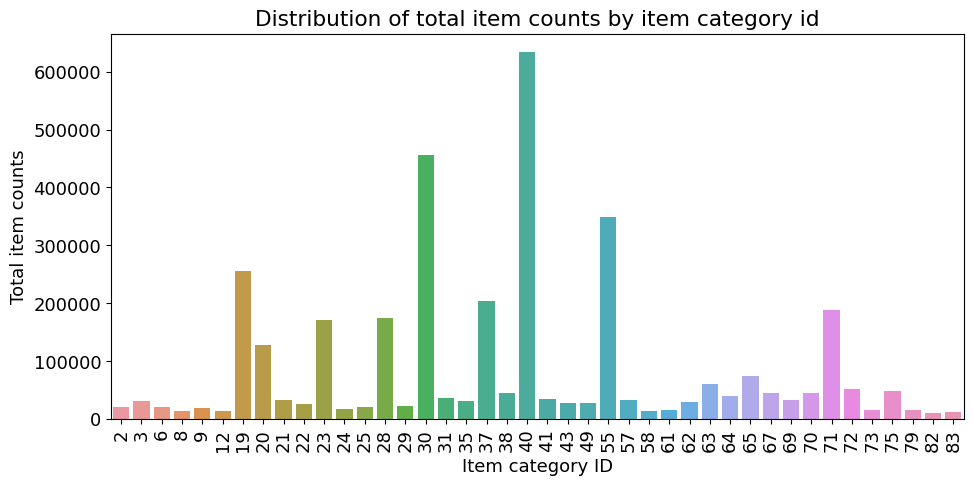

In [41]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# 총 판매량이 10,000개를 초과하는 상품분류만 추출
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] > 10000]

# 상품분류별 총 상품 판매량 막대그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # x축 라벨 회전

-> 중요한 카테로리 파악 / 40이 가장 높게 나타남 

### 상점별 판매량
- 월간 판매량 10,000개 초과인 상점만 추출해서 시각화

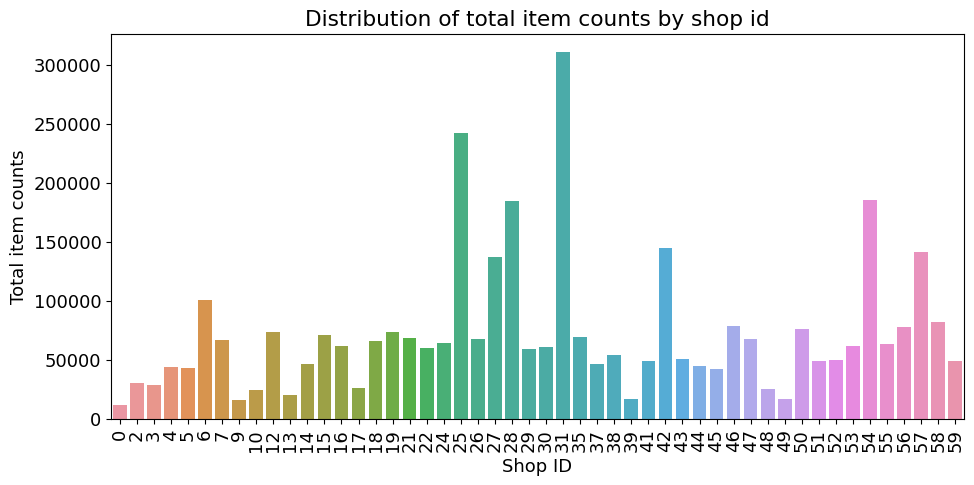

In [42]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# 상점별 총 상품 판매량
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

#   > 10000 임계값 정해주고 시각화 
group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

# 상점별 총 상품 판매량 막대그래프
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

-> 샵 아이디 31인경우가 판매량 제일 많음 (어디인진 모르겠지만)

### 분석 결과
- [분석 결과] 월별 판매량만 구하면 되니 date 피처 제거
- [분석 결과] 타깃값 = date_block_num 피처의 값이 같은 데이터들의 item_cnt_day 값의 합
- [분석 결과] 훈련 데이터 중 가장 최근인 2015년 10월 판매 내역을 검증 데이터로 사용
- [분석 결과] 메모리 관리 필요
- [분석 결과] 상점 이름의 첫 단어는 도시를 뜻함
- [분석 결과] shop_id를 기준으로 sales_train과 shops 병합
- [분석 결과] 상품명 피처 제거
- [분석 결과] item_id를 기준으로 sales_train과 items 병합
- [분석 결과] item_category_id를 기준으로 sales_train과 item_categories 병합
- [분석 결과] 상품분류명에서 첫 단어는 대분류
- [분석 결과] 모든 데이터에 결측값 없음
- [분석 결과] 상점ID, 상품ID, 상품분류ID는 각각 상점명, 상품명, 상품분류명과 1:1 매칭되므로 둘 중 하나 제거
- [분석 결과] 일별 판매량 1,000 이상인 데이터(이상치) 제거

### 분석 정리
1. 판매량 관련 피처 값은 모두 0~20 사이로 제한해야 함
2. 시계열 데이터이므로 데이터 순서를 꼭 지켜야 함(검증 데이터는 최근 1개월치 이용)
3. 타깃값 : 같은 달 일별 판매량을 합쳐 타깃값(월별 판매량)을 구해야 함
4. 데이터 병합 : 추가 정보 파일(상점, 상품, 상품분류)은 각각의 ID(상점ID, 상품ID, 상품분류ID)를 기준으로 훈련 데이터에 병합할 수 있음
5. 다양한 피처 엔지니어링 후 데이터 크기가 커서 메모리 관리 필요
6. 파생 피처 추가 : 상점명과 상품분류명의 첫 단어는 각각 도시와 대분류
7. 피처 제거 : 월별 판매량만 구하면 되니 date 피처 필요 없음
8. 피처 제거 : 상점ID, 상품ID, 상품분류ID는 각각 상점명, 상품명, 상품분류명과 1:1로 매칭되므로 둘 중 하나만 있으면 됨
9. 이상치 제거 : 일별 판매량과 판매가에는 값이 이상치가 있어서 제거 필요
10. 모든 데이터에서 결측값이 없음